In [1]:
import numpy as np

from TraceSimulator import TraceSimulator
from trace_IO import *
from OptimumFilter import *
from OF import *
import matplotlib.pyplot as plt


In [2]:
sampling_frequency = 3906250
template_1 = np.load("./sub_ch_template.npy")
template_2 = np.load("./vac_ch45_low_eng.npy")
template_3 = np.load("./vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger_1 = OFtrigger(template_1, noise_psd, sampling_frequency)
trigger_2 = OFtrigger(template_2, noise_psd, sampling_frequency)
trigger_3 = OFtrigger(template_3, noise_psd, sampling_frequency)


In [3]:
loaded_traces = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces.shape

(1000, 54, 32768)

In [4]:
n_events = loaded_traces.shape[0]
n_channels = loaded_traces.shape[1]

# Arrays to store amplitudes and chisq values for all events
all_amps = np.zeros((n_events, n_channels))
all_chisqs = np.zeros((n_events, n_channels))

# Optional: templates for plotting/debugging
templates = {
    "1": trigger_1._template,
    "2": trigger_2._template,
    "3": trigger_3._template,
}

for i in range(n_events):
    traces = loaded_traces[i]  # shape: (54, 32768)

    for ch in range(n_channels):
        if ch <= 44:
            amp, chisq = trigger_1.fit(traces[ch])
        elif ch == 45:
            amp, chisq = trigger_2.fit(traces[ch])
        else:
            amp, chisq = trigger_3.fit(traces[ch])

        all_amps[i, ch] = amp
        all_chisqs[i, ch] = chisq


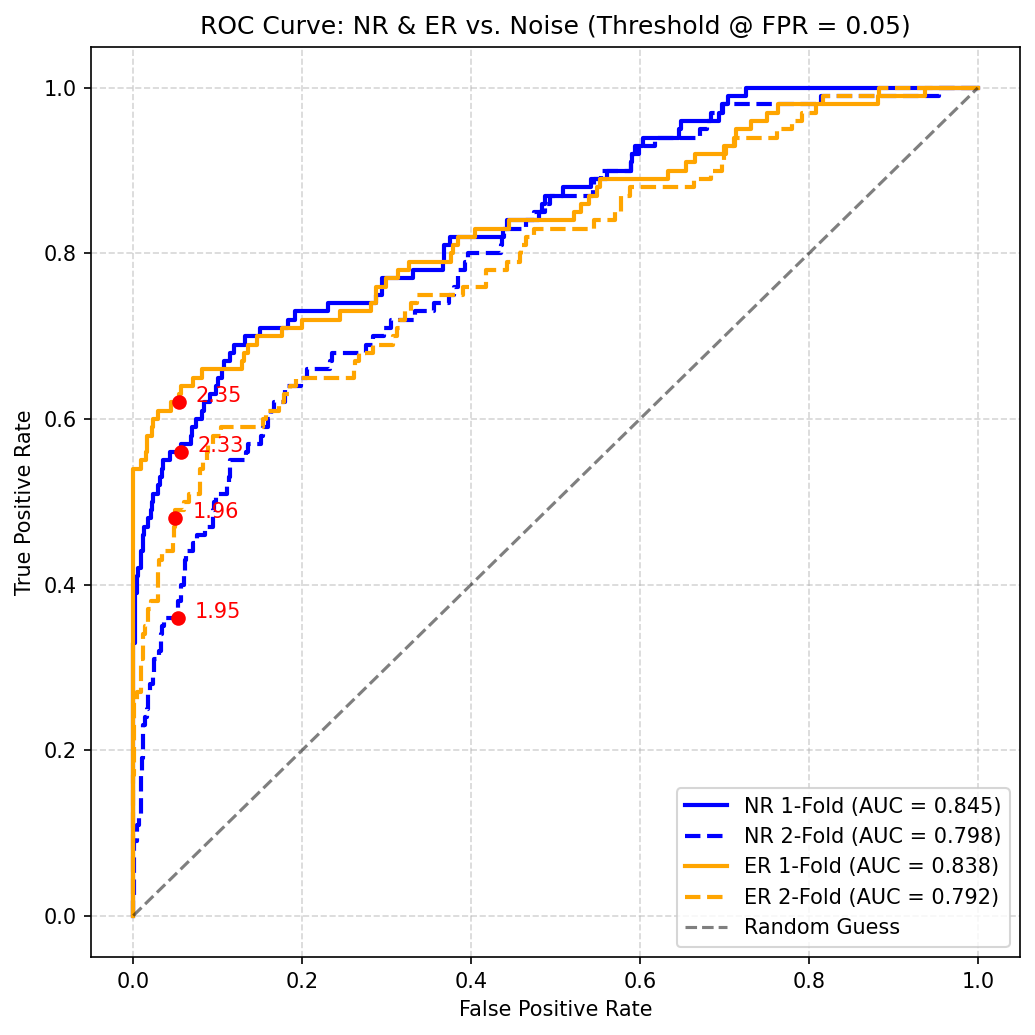

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# === Load traces ===
loaded_traces_neg = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces_NR = load_traces_from_zstd("/ceph/dwong/trigger_samples/NR/traces_energy_30.zst", n_traces=100)
loaded_traces_ER = load_traces_from_zstd("/ceph/dwong/trigger_samples/ER/traces_energy_30.zst", n_traces=100)

def compute_amplitudes(traces):
    n_events = traces.shape[0]
    n_channels = traces.shape[1]
    all_amps = np.zeros((n_events, n_channels))
    for i in range(n_events):
        event = traces[i]
        for ch in range(n_channels):
            if ch <= 44:
                amp, _ = trigger_1.fit(event[ch])
            elif ch == 45:
                amp, _ = trigger_2.fit(event[ch])
            else:
                amp, _ = trigger_3.fit(event[ch])
            all_amps[i, ch] = amp
    return all_amps

# === Compute amplitudes ===
amps_neg = compute_amplitudes(loaded_traces_neg)
amps_NR  = compute_amplitudes(loaded_traces_NR)
amps_ER  = compute_amplitudes(loaded_traces_ER)

# === Score functions ===
def fold_scores(amps, fold_n):
    return np.partition(amps, -fold_n, axis=1)[:, -fold_n]

score_1fold_neg = np.max(amps_neg, axis=1)
score_2fold_neg = fold_scores(amps_neg, 2)

score_1fold_NR = np.max(amps_NR, axis=1)
score_2fold_NR = fold_scores(amps_NR, 2)

score_1fold_ER = np.max(amps_ER, axis=1)
score_2fold_ER = fold_scores(amps_ER, 2)

# === ROC + threshold finder ===
def compute_roc_with_threshold(scores_signal, scores_noise, target_fpr=0.05):
    y_true = np.concatenate([np.zeros_like(scores_noise), np.ones_like(scores_signal)])
    y_scores = np.concatenate([scores_noise, scores_signal])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_val = auc(fpr, tpr)
    idx = np.argmin(np.abs(fpr - target_fpr))
    return fpr, tpr, auc_val, thresholds[idx], fpr[idx], tpr[idx]

# === Compute all curves ===
fpr_NR_1, tpr_NR_1, auc_NR_1, th_NR_1, fx_NR_1, ty_NR_1 = compute_roc_with_threshold(score_1fold_NR, score_1fold_neg)
fpr_NR_2, tpr_NR_2, auc_NR_2, th_NR_2, fx_NR_2, ty_NR_2 = compute_roc_with_threshold(score_2fold_NR, score_2fold_neg)
fpr_ER_1, tpr_ER_1, auc_ER_1, th_ER_1, fx_ER_1, ty_ER_1 = compute_roc_with_threshold(score_1fold_ER, score_1fold_neg)
fpr_ER_2, tpr_ER_2, auc_ER_2, th_ER_2, fx_ER_2, ty_ER_2 = compute_roc_with_threshold(score_2fold_ER, score_2fold_neg)

# === Plot ===
plt.figure(figsize=(7, 7), dpi=150)

# NR
plt.plot(fpr_NR_1, tpr_NR_1, color='blue', linewidth=2, label=f"NR 1-Fold (AUC = {auc_NR_1:.3f})")
plt.plot(fpr_NR_2, tpr_NR_2, '--', color='blue', linewidth=2, label=f"NR 2-Fold (AUC = {auc_NR_2:.3f})")
plt.plot(fx_NR_1, ty_NR_1, 'ro')
plt.text(fx_NR_1 + 0.02, ty_NR_1, f'{th_NR_1:.2f}', color='red')
plt.plot(fx_NR_2, ty_NR_2, 'ro')
plt.text(fx_NR_2 + 0.02, ty_NR_2, f'{th_NR_2:.2f}', color='red')

# ER
plt.plot(fpr_ER_1, tpr_ER_1, color='orange', linewidth=2, label=f"ER 1-Fold (AUC = {auc_ER_1:.3f})")
plt.plot(fpr_ER_2, tpr_ER_2, '--', color='orange', linewidth=2, label=f"ER 2-Fold (AUC = {auc_ER_2:.3f})")
plt.plot(fx_ER_1, ty_ER_1, 'ro')
plt.text(fx_ER_1 + 0.02, ty_ER_1, f'{th_ER_1:.2f}', color='red')
plt.plot(fx_ER_2, ty_ER_2, 'ro')
plt.text(fx_ER_2 + 0.02, ty_ER_2, f'{th_ER_2:.2f}', color='red')

# Random guess
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: NR & ER vs. Noise (Threshold @ FPR = 0.05)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


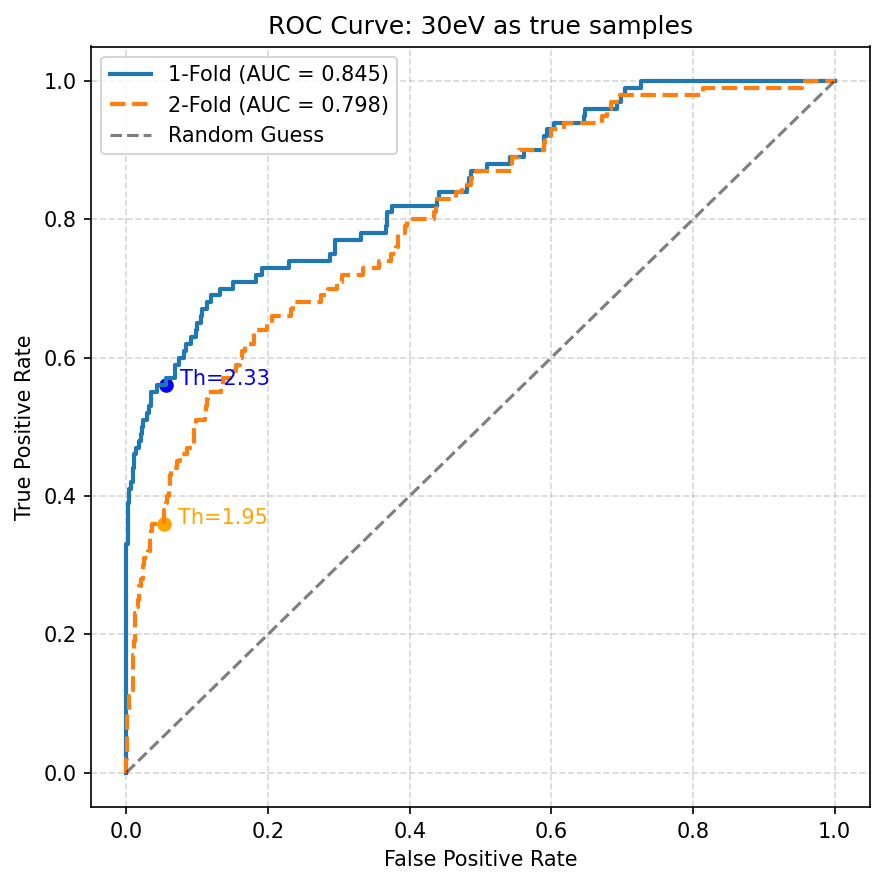

In [16]:
def find_threshold_at_fpr(fpr, thresholds, target_fpr=0.05):
    """Return the threshold corresponding to the closest FPR to target_fpr."""
    idx = np.argmin(np.abs(fpr - target_fpr))
    return thresholds[idx], fpr[idx], idx

# Get thresholds for both scores
fpr_1, tpr_1, thresholds_1 = roc_curve(y_true, scores_1fold)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_true, scores_2fold)

# Choose a target FPR to annotate
target_fpr = 0.05

thresh_1, fpr_val_1, idx_1 = find_threshold_at_fpr(fpr_1, thresholds_1, target_fpr)
thresh_2, fpr_val_2, idx_2 = find_threshold_at_fpr(fpr_2, thresholds_2, target_fpr)

# === Plot with annotations ===
plt.figure(figsize=(6, 6), dpi=150)
plt.plot(fpr_1, tpr_1, label=f"1-Fold (AUC = {auc(fpr_1, tpr_1):.3f})", linewidth=2)
plt.plot(fpr_2, tpr_2, '--', label=f"2-Fold (AUC = {auc(fpr_2, tpr_2):.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Random Guess")

# Annotate thresholds
plt.scatter([fpr_val_1], [tpr_1[idx_1]], color='blue')
plt.text(fpr_val_1 + 0.02, tpr_1[idx_1], f'Th={thresh_1:.2f}', color='blue')

plt.scatter([fpr_val_2], [tpr_2[idx_2]], color='orange')
plt.text(fpr_val_2 + 0.02, tpr_2[idx_2], f'Th={thresh_2:.2f}', color='orange')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 30eV as true samples")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Processing ER energy = 5 eV
Processing ER energy = 10 eV
Processing ER energy = 15 eV
Processing ER energy = 20 eV
Processing ER energy = 25 eV
Processing ER energy = 30 eV
Processing ER energy = 35 eV
Processing ER energy = 40 eV
Processing ER energy = 45 eV
Processing ER energy = 50 eV


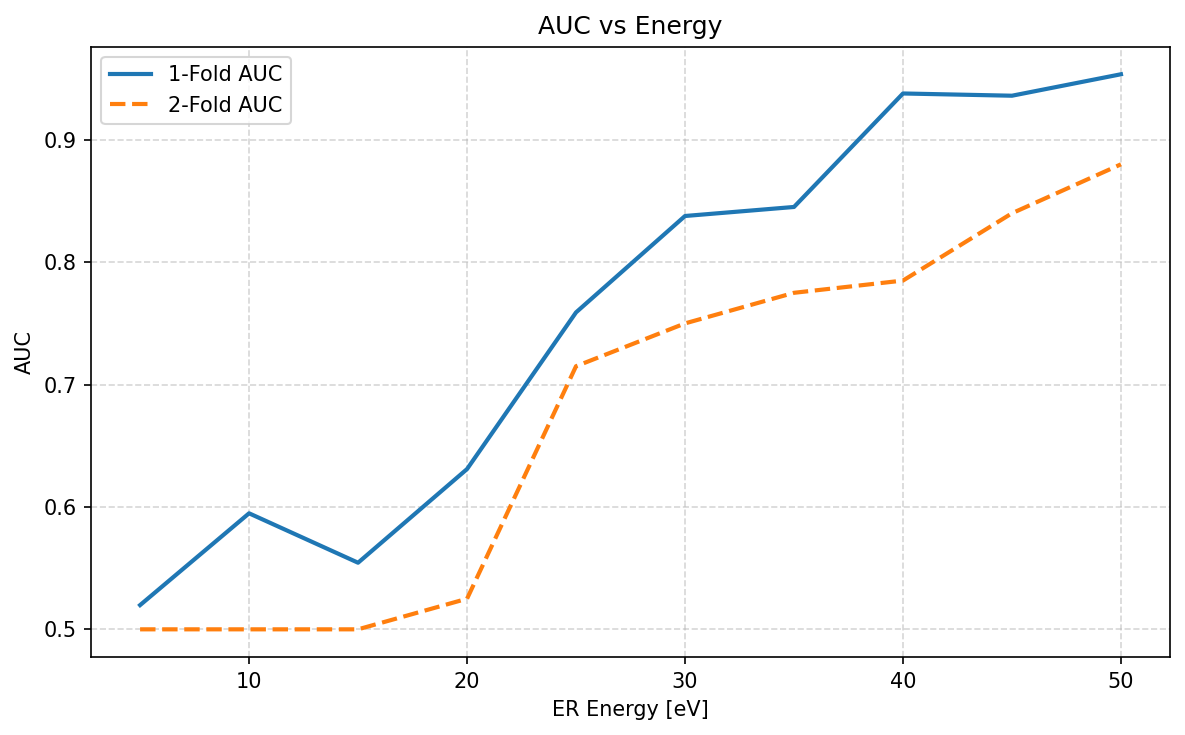

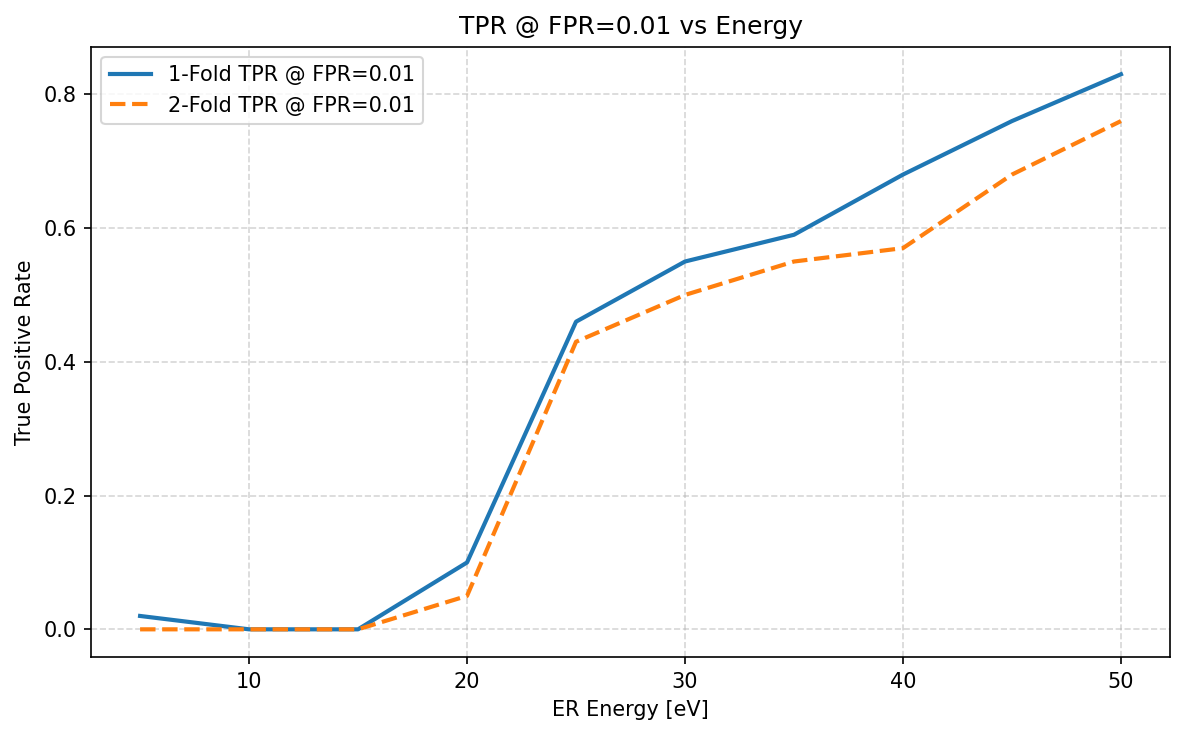

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def compute_amplitudes(traces):
    n_events = traces.shape[0]
    n_channels = traces.shape[1]
    all_amps = np.zeros((n_events, n_channels))

    for i in range(n_events):
        event = traces[i]
        for ch in range(n_channels):
            if ch <= 44:
                amp, _ = trigger_1.fit(event[ch])
            elif ch == 45:
                amp, _ = trigger_2.fit(event[ch])
            else:
                amp, _ = trigger_3.fit(event[ch])
            all_amps[i, ch] = amp

    return all_amps

# === Load background (noise)
loaded_traces_neg = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
amps_neg = compute_amplitudes(loaded_traces_neg)

# === Energy scan
energies = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Add more if you have
threshold_value = 3.0
fpr_target = 0.01

auc_1_list = []
auc_2_list = []
tpr_1_list = []
tpr_2_list = []

for energy in energies:
    print(f"Processing ER energy = {energy} eV")

    path = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    loaded_traces_pos = load_traces_from_zstd(path, n_traces=100)
    amps_pos = compute_amplitudes(loaded_traces_pos)

    # Scores
    score_1fold_pos = amps_pos.max(axis=1)
    score_1fold_neg = amps_neg.max(axis=1)

    score_2fold_pos = (amps_pos > threshold_value).sum(axis=1)
    score_2fold_neg = (amps_neg > threshold_value).sum(axis=1)

    # Labels
    y_true = np.concatenate([
        np.ones(len(score_1fold_pos)),
        np.zeros(len(score_1fold_neg))
    ])

    # 1-fold
    scores_1 = np.concatenate([score_1fold_pos, score_1fold_neg])
    fpr_1, tpr_1, _ = roc_curve(y_true, scores_1)
    auc_1 = auc(fpr_1, tpr_1)
    auc_1_list.append(auc_1)

    # Get TPR at desired FPR
    idx = np.searchsorted(fpr_1, fpr_target, side="right") - 1
    tpr_1_list.append(tpr_1[idx] if idx >= 0 else 0)

    # 2-fold
    scores_2 = np.concatenate([score_2fold_pos, score_2fold_neg])
    fpr_2, tpr_2, _ = roc_curve(y_true, scores_2)
    auc_2 = auc(fpr_2, tpr_2)
    auc_2_list.append(auc_2)

    idx = np.searchsorted(fpr_2, fpr_target, side="right") - 1
    tpr_2_list.append(tpr_2[idx] if idx >= 0 else 0)

# === Plot AUC vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, auc_1_list, label="1-Fold AUC", linewidth=2)
plt.plot(energies, auc_2_list, '--', label="2-Fold AUC", linewidth=2)
plt.xlabel("ER Energy [eV]")
plt.ylabel("AUC")
plt.title("AUC vs Energy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot TPR@FPR=0.01 vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, tpr_1_list, label="1-Fold TPR @ FPR=0.01", linewidth=2)
plt.plot(energies, tpr_2_list, '--', label="2-Fold TPR @ FPR=0.01", linewidth=2)
plt.xlabel("ER Energy [eV]")
plt.ylabel("True Positive Rate")
plt.title("TPR @ FPR=0.01 vs Energy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
all_amps.shape

(1000, 54)